In [1]:
autosave 0

Autosave disabled


# Testing the Variable Projection method for Separable non-linear problems

In this notebook we are going to test and explore the variable projection method (Golub and Pereyra, 1973) on a simple exponential fitting problem. This kind of inverse problem falls into the set of separable non-linear problems; therefore, the variable-projection method (VarPro) can and should be applied. The analytical/modeling equation is represented by the following:
\begin{align}
y_{i} = a \exp(-b t_{i}),
\end{align}
where $a$ and $b$ are the model parameters and $t_i$ indicates the $i-th$ time sample. We are going to minimize the simple $L_{2}$ difference between the model and the observed data. Hence, we can write the objective function as the following:
\begin{align}
\phi(a,b) = \frac{1}{2} \|\mathbf{y}(a,b) - \mathbf{y}_{obs} \|_2^2.
\end{align}
We notice that this objective function is quadratic with respect to parameter $a$ and non-linear with respect to the other.

### Importing necessary libraries

In [2]:
#Adding library modules to PYTHONPATH
import sys
sys.path.append("../python")
import numpy as np
#Inversion library-related modules
import pyVector as Vec
import pyOperator as Op
import pyProblem as Prblm
import pyStopper as Stopper
import time
#Solvers
from pyLinearSolver import LCGsolver as LCG
from pyNonLinearSolver import NLCGsolver as NLCG
from pyNonLinearSolver import LBFGSsolver as LBFGS
#Plotting library
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


### Defining non-linear modeling operator for symultaneous inversion
Here we define the model vector as $\mathbf{m}= [a,b]^{T}$

In [3]:
class exponential_nl_sym(Op.Operator):

    def __init__(self,model,t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        self.setDomainRange(model,t_vec)
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self,add,model,data):
        """Forward non-linear"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        a = modelNd[0]
        b = modelNd[1]
        if(not add): data.zero()
        dataNd += a * np.exp(-b*self.t_samples)
        return
    
class exponential_jac_sym(Op.Operator):

    def __init__(self,model,t_vec):
        """Jacobian matrix of the non-linear exponential for symultaneous inversion"""
        self.setDomainRange(model,t_vec)
        self.m0 = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self,add,model,data):
        """Forward jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        da = modelNd[0]
        db = modelNd[1]
        a0 = self.m0.getNdArray()[0]
        b0 = self.m0.getNdArray()[1]
        if(not add): data.zero()
        dataNd += da * np.exp(-b0*self.t_samples) - a0 * self.t_samples * db* np.exp(-b0*self.t_samples)
        return
    
    def adjoint(self,add,model,data):
        """Adjoint jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        da = modelNd[0]
        db = modelNd[1]
        a0 = self.m0.getNdArray()[0]
        b0 = self.m0.getNdArray()[1]
        if(not add): model.zero()
        modelNd[0] += np.sum(dataNd*np.exp(-b0*self.t_samples))
        modelNd[1] -= np.sum(dataNd*a0*self.t_samples*np.exp(-b0*self.t_samples))
        return
    
    def set_m0(self,m0):
        self.m0.copy(m0)
        return

In [4]:
#Generating observed data
time_vec = Vec.vectorIC(np.linspace(0.,2.,200))
a_true = 10.0
b_true = 1.0
true_m = Vec.vectorIC(np.array([a_true,b_true]))
modeling_op = exponential_nl_sym(true_m,time_vec)
data_true = time_vec.clone()
modeling_op.forward(False,true_m,data_true)

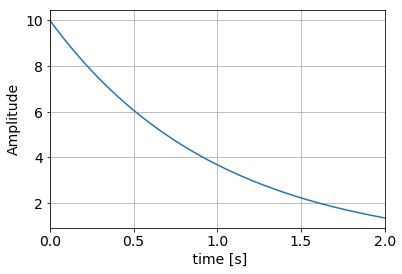

In [5]:
fig,ax=plt.subplots()
plt.plot(time_vec.getNdArray(),data_true.getNdArray())
plt.grid()
# plt.title("Observed data points")
plt.xlabel(" time [s]")
plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.savefig('exp-obs-vp-data.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [6]:
#Generating Jacobian of the non-linear operator
modeling_op_jac = exponential_jac_sym(true_m,time_vec)
non_lin_op = Op.NonLinearOperator(modeling_op,modeling_op_jac,modeling_op_jac.set_m0)
#Instanciating non-linear problem
L2_sym = Prblm.ProblemL2NonLinear(true_m,data_true,non_lin_op)

In [7]:
#Computing the objective function for plotting
a_samples = np.linspace(0.0,30.0,500)
b_samples = np.linspace(-1.0,6.0,200)
obj_l2 = np.zeros((len(a_samples),len(b_samples)))
model_test = Vec.vectorIC(np.array((0.0,0.0)))
model_test_np = model_test.getNdArray()
for ia,a_value in enumerate(a_samples):
        for ib,b_value in enumerate(b_samples):
                model_test_np[0] = a_value
                model_test_np[1] = b_value
                obj_l2[ia,ib]=L2_sym.get_obj(model_test)

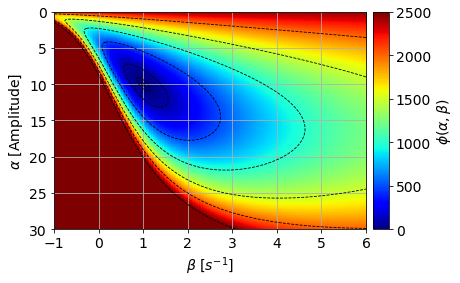

In [8]:
#Looking at the shape of the objective function
fig,ax=plt.subplots()
im=plt.imshow(obj_l2,vmin=0.0,vmax=2500,cmap='jet',extent=[-1.0,6.0,30.0,0.0])
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r"$\alpha$ "+"[Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],extent=[-1.0,6.0,0.0,30.0],
                 colors="black",linewidths=(0.8,),linestyles=('--'))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\phi(\alpha,\beta)$')
ax.set_aspect('auto')
plt.savefig('exp-obj-func.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [9]:
niter = 1000
Stop  = Stopper.BasicStopper(niter=niter,tolr=1e-32,tolg=1e-32)
NLCGsolver = NLCG(Stop,beta_type="FR")
model_init = model_test
model_initNp = model_init.getNdArray()
a_initial = 2.0
b_initial = 0.0
model_initNp[0] = a_initial
model_initNp[1] = b_initial
#Setting initial model
_=L2_sym.get_obj(model_init)
L2_sym.setDefaults()
NLCGsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
NLCGsolver.run(L2_sym,verbose=True)
print("Computational time %s s"%(time.time()-t0))
objNLCG = np.copy(NLCGsolver.obj)
#Converting sampled points to arrays for plotting
a_smpld=[]
b_smpld=[]
for iter in range(len(NLCGsolver.model)):
    a_smpld.append(NLCGsolver.model[iter].getNdArray()[0])
    b_smpld.append(NLCGsolver.model[iter].getNdArray()[1])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER 
	Restart folder: /tmp/restart_2020-07-16T11-54-20.752997/
	Conjugate method used: FR
##########################################################################################

iter = 0000, obj = 1.13543e+03, resnorm = 4.77e+01, gradnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 9.96829e+02, resnorm = 4.47e+01, gradnorm = 3.24e+02, feval = 4, geval = 2
iter = 0002, obj = 8.41188e+02, resnorm = 4.10e+01, gradnorm = 1.30e+03, feval = 7, geval = 3
iter = 0003, obj = 7.44506e+01, resnorm = 1.22e+01, gradnorm = 2.48e+02, feval = 10, geval = 4
iter = 0004, obj = 5.25159e+01, resnorm = 1.02e+01, gradnorm = 8.37e+01, feval = 13, geval = 5
iter = 0005, obj = 5.01772e+01, resnorm = 1.00e+01, gradnorm = 4.34e+01, feval = 16, geval = 6
iter = 0006, obj = 4.78102e+01, resnorm = 9.78e+00, gradnorm = 1.03e+02, feval = 19, geval = 7
iter = 0007, obj = 3.51325e+0

iter = 0130, obj = 5.86230e-14, resnorm = 3.42e-07, gradnorm = 1.30e-05, feval = 391, geval = 131
iter = 0131, obj = 3.89056e-14, resnorm = 2.79e-07, gradnorm = 5.22e-06, feval = 394, geval = 132
iter = 0132, obj = 3.59034e-14, resnorm = 2.68e-07, gradnorm = 2.12e-06, feval = 397, geval = 133
iter = 0133, obj = 3.53294e-14, resnorm = 2.66e-07, gradnorm = 1.27e-06, feval = 400, geval = 134
iter = 0134, obj = 3.49415e-14, resnorm = 2.64e-07, gradnorm = 1.58e-06, feval = 403, geval = 135
iter = 0135, obj = 3.35938e-14, resnorm = 2.59e-07, gradnorm = 3.38e-06, feval = 406, geval = 136
iter = 0136, obj = 2.68675e-14, resnorm = 2.32e-07, gradnorm = 6.96e-06, feval = 409, geval = 137
iter = 0137, obj = 1.26721e-14, resnorm = 1.59e-07, gradnorm = 6.99e-06, feval = 412, geval = 138
iter = 0138, obj = 5.90902e-15, resnorm = 1.09e-07, gradnorm = 3.31e-06, feval = 415, geval = 139
iter = 0139, obj = 4.68654e-15, resnorm = 9.68e-08, gradnorm = 1.29e-06, feval = 418, geval = 140
iter = 0140, obj = 4

iter = 0217, obj = 4.63609e-24, resnorm = 3.05e-12, gradnorm = 1.44e-11, feval = 652, geval = 218
iter = 0218, obj = 4.58832e-24, resnorm = 3.03e-12, gradnorm = 1.54e-11, feval = 655, geval = 219
iter = 0219, obj = 4.33979e-24, resnorm = 2.95e-12, gradnorm = 4.04e-11, feval = 658, geval = 220
iter = 0220, obj = 4.11263e-24, resnorm = 2.87e-12, gradnorm = 6.62e-11, feval = 661, geval = 221
iter = 0221, obj = 3.33997e-24, resnorm = 2.58e-12, gradnorm = 9.53e-11, feval = 664, geval = 222
iter = 0222, obj = 2.20425e-24, resnorm = 2.10e-12, gradnorm = 9.21e-11, feval = 667, geval = 223
iter = 0223, obj = 1.48705e-24, resnorm = 1.72e-12, gradnorm = 6.04e-11, feval = 670, geval = 224
iter = 0224, obj = 1.22648e-24, resnorm = 1.57e-12, gradnorm = 3.31e-11, feval = 673, geval = 225
iter = 0225, obj = 1.15177e-24, resnorm = 1.52e-12, gradnorm = 1.69e-11, feval = 676, geval = 226
iter = 0226, obj = 1.13332e-24, resnorm = 1.51e-12, gradnorm = 9.62e-12, feval = 679, geval = 227
iter = 0227, obj = 1

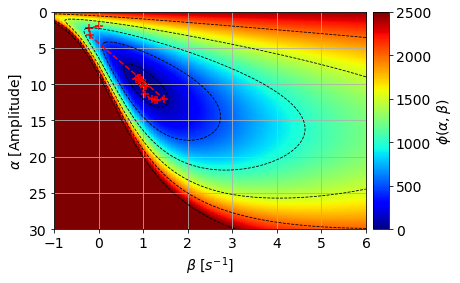

In [10]:
#Looking at the optimization path
fig,ax=plt.subplots()
plt.scatter(b_smpld,a_smpld,color='red',s=50,marker="+")
plt.plot(b_smpld,a_smpld,"--",color='red')
im=plt.imshow(obj_l2,vmin=0.0,vmax=2500,cmap='jet',extent=[-1.0,6.0,30.0,0.0])
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r"$\alpha$ "+"[Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],extent=[-1.0,6.0,0.0,30.0],
                 colors="black",linewidths=(0.8,),linestyles=('--'))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\phi(\alpha,\beta)$')
ax.set_aspect('auto')
plt.savefig('exp-obj-NLCG.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [11]:
BFGSsolver = LBFGS(Stop)
#Setting initial model
_=L2_sym.get_obj(model_init)
L2_sym.setDefaults()
BFGSsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
BFGSsolver.run(L2_sym,verbose=True)
objBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s"%(time.time()-t0))
#Converting sampled points to arrays for plotting
a_smpld=[]
b_smpld=[]
for iter in range(len(BFGSsolver.model)):
    a_smpld.append(BFGSsolver.model[iter].getNdArray()[0])
    b_smpld.append(BFGSsolver.model[iter].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2020-07-16T11-54-25.647838/
##########################################################################################

iter = 0000, obj = 1.13543e+03, resnorm = 4.77e+01, gradnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 1.11043e+03, resnorm = 4.71e+01, gradnorm = 1.60e+03, feval = 2, geval = 2
iter = 0002, obj = 8.57238e+02, resnorm = 4.14e+01, gradnorm = 3.54e+02, feval = 3, geval = 3
iter = 0003, obj = 7.01722e+02, resnorm = 3.75e+01, gradnorm = 3.41e+02, feval = 4, geval = 4
iter = 0004, obj = 2.47522e+02, resnorm = 2.22e+01, gradnorm = 4.44e+02, feval = 5, geval = 5
iter = 0005, obj = 1.32921e+02, resnorm = 1.63e+01, gradnorm = 4.20e+02, feval = 6, geval = 6
iter = 0006, obj = 4.55506e+01, resnorm = 9.54e+00, gradnorm = 3.18e+02, feval = 7, geval = 7
iter = 0007, obj = 7.69313e+00, resnorm = 3.92e+00,

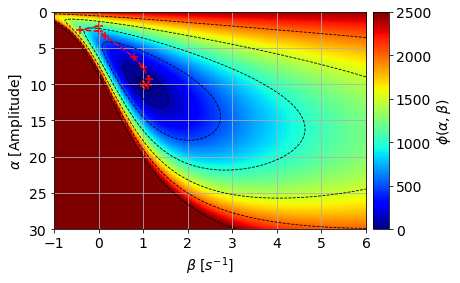

In [12]:
#Looking at the optimization path
fig,ax=plt.subplots()
plt.scatter(b_smpld,a_smpld,color='red',s=50,marker="+")
plt.plot(b_smpld,a_smpld,"--",color='red')
im=plt.imshow(obj_l2,vmin=0.0,vmax=2500,cmap='jet',extent=[-1.0,6.0,30.0,0.0])
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r"$\alpha$ "+"[Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],extent=[-1.0,6.0,0.0,30.0],
                 colors="black",linewidths=(0.8,),linestyles=('--'))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\phi(\alpha,\beta)$')
ax.set_aspect('auto')
plt.savefig('exp-obj-BFGS.pdf', format='pdf', dpi=300, bbox_inches='tight')

Let's try to apply the VarPro method. Therefore, we reduce the number of model parameter to only $b$ because now $a$ is going to be function of $b$. In fact, we can write the new objective function as the following:
\begin{align}
\phi_{VarPro}(b) =  \frac{1}{2} \|\mathbf{y}(a_{opt}(b),b) - \mathbf{y}_{obs} \|_2^2,
\end{align}
where $a_{opt}(b)$ is given by:
\begin{align}
a_{opt}(b) = \frac{\exp(-b\mathbf{t})^{T}\mathbf{y}_{obs}}{\|\exp(-b\mathbf{t})\|_2^2},
\end{align}
which is the minimizer of the following quadratic problem for a fix $b$:
\begin{align}
\phi_{Lin}(a) =  \frac{1}{2} \|a \exp(-b\mathbf{t}) - \mathbf{y}_{obs} \|_2^2.
\end{align}

In [13]:
#Computing optimal a for each b
a_opt = []
t_samples = time_vec.getNdArray()
data_trueNp = data_true.getNdArray()
for ib,b_value in enumerate(b_samples):
    expb = np.exp(-b_value*t_samples)
    a_opt.append(np.dot(expb,data_trueNp)/np.dot(expb,expb))

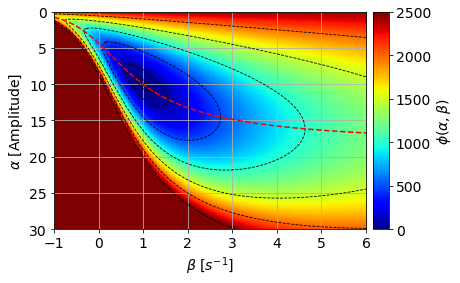

In [14]:
#Looking at the shape of the objective function and the curve along the optimal a
fig,ax=plt.subplots()
plt.plot(b_samples,a_opt,"--",color='red')
im=plt.imshow(obj_l2,vmin=0.0,vmax=2500,cmap='jet',extent=[-1.0,6.0,30.0,0.0])
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r"$\alpha$ "+"[Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],extent=[-1.0,6.0,0.0,30.0],
                 colors="black",linewidths=(0.8,),linestyles=('--'))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\phi(\alpha,\beta)$')
ax.set_aspect('auto')
plt.savefig('exp-obj-VarPro-proj.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [15]:
#Computing the objective function along curve of the optimal a
obj_l2_vp = []
for ib,b_value in enumerate(b_samples):
    model_test_np[0] = a_opt[ib]
    model_test_np[1] = b_value
    obj_l2_vp.append(L2_sym.get_obj(model_test))

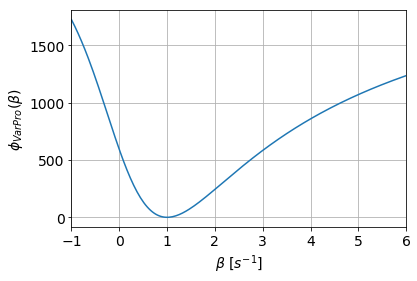

In [16]:
fig,ax=plt.subplots()
plt.plot(b_samples,obj_l2_vp)
plt.grid()
# plt.title("VarPro objective function")
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r'$\phi_{VarPro}(\beta)$')
ax.autoscale(enable=True, axis='x', tight=True)
plt.savefig('exp-obj-VarPro.pdf', format='pdf', dpi=300, bbox_inches='tight')

Now let's solve the problem using the variable projection method. First, we need to create some operator to solve the linear problem when we fix the non-linear component of it.

In [17]:
class exponential_lin_op(Op.Operator):

    def __init__(self,model,t_vec):
        self.setDomainRange(model,t_vec)
        self.t_samples = t_vec.getNdArray()
        self.nl_model = model.clone()
        return

    def forward(self,add,model,data):
        """Forward jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        b = self.nl_model.getNdArray()[0]
        if(not add): data.zero()
        dataNd += modelNd[0] * np.exp(-b*self.t_samples)
        return
    
    def adjoint(self,add,model,data):
        """Adjoint jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        b = self.nl_model.getNdArray()[0]
        if(not add): model.zero()
        modelNd[0] += np.sum(dataNd*np.exp(-b*self.t_samples))
        return
    
    def set_nl(self,nl_model):
        """Function to set the non-linear component of the operator"""
        self.nl_model.copy(nl_model)
        return

Secondly, let's create the operator to solve the non-linear problem in the reduced space.

In [18]:
class exponential_nl_vp(Op.Operator):

    def __init__(self,model,t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        self.setDomainRange(model,t_vec)
        self.t_samples = t_vec.getNdArray()
        self.lin_model = model.clone()
        return

    def forward(self,add,model,data):
        """Forward non-linear"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        a = self.lin_model.getNdArray()[0]
        b = modelNd[0]
        if(not add): data.zero()
        dataNd += a * np.exp(-b*self.t_samples)
        return
    
    def set_lin(self,lin_model):
        """Function to set the linear component of the operator"""
        self.lin_model.copy(lin_model)
        return

class exponential_jac_vp(Op.Operator):

    def __init__(self,model,t_vec):
        """Jacobian matrix of the non-linear exponential for VarPro inversion"""
        self.setDomainRange(model,t_vec)
        self.m0 = model.clone()
        self.lin_model = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self,add,model,data):
        """Forward jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        db = modelNd[0]
        a = self.lin_model.getNdArray()[0]
        b0 = self.m0.getNdArray()[0]
        if(not add): data.zero()
        dataNd += - a * self.t_samples * db* np.exp(-b0*self.t_samples)
        return
    
    def adjoint(self,add,model,data):
        """Adjoint jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        a = self.lin_model.getNdArray()[0]
        b0 = self.m0.getNdArray()[0]
        if(not add): model.zero()
        modelNd[0] -= np.sum(dataNd*a*self.t_samples*np.exp(-b0*self.t_samples))
        return
    
    def set_m0(self,m0):
        self.m0.copy(m0)
        return
    
    def set_lin(self,lin_model):
        """Function to set the linear component of the operator"""
        self.lin_model.copy(lin_model)
        return

In [19]:
a_init = Vec.vectorIC(np.array([a_initial]))
b_init = Vec.vectorIC(np.array([b_initial]))
#Creating non-linear operator
expon_nl = exponential_nl_vp(b_init,time_vec)
expon_nl.set_lin(a_init)
#Creating VP operator
expon_nl_jac = exponential_jac_vp(b_init,time_vec)
exp_nl_op = Op.NonLinearOperator(expon_nl,expon_nl_jac,expon_nl_jac.set_m0)
expon_lin = exponential_lin_op(a_init,time_vec)
exp_vp_op = Op.VpOperator(exp_nl_op,expon_lin,expon_lin.set_nl,expon_nl_jac.set_lin,
                               set_lin=expon_nl.set_lin)
#Instantiating VarPro problem object
#Create solver for linear inverse problem
LCGsolver = LCG(Stopper.BasicStopper(niter=10))
VPproblem = Prblm.ProblemL2VpReg(b_init,a_init,exp_vp_op,data_true,LCGsolver)

In [20]:
BFGSsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
BFGSsolver.run(VPproblem,verbose=True)
objVPBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s"%(time.time()-t0))
#Converting sampled points to arrays for plotting
b_smpld=[]
for iter in range(len(BFGSsolver.model)):
    b_smpld.append(BFGSsolver.model[iter].getNdArray()[0])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2020-07-16T11-54-25.647838/
##########################################################################################

iter = 0000, obj = 5.92480e+02, resnorm = 3.44e+01, gradnorm = 1.18e+03, feval = 1, geval = 1
iter = 0001, obj = 3.29176e+01, resnorm = 8.11e+00, gradnorm = 2.00e+02, feval = 8, geval = 8
iter = 0002, obj = 5.12584e+00, resnorm = 3.20e+00, gradnorm = 8.84e+01, feval = 9, geval = 9
iter = 0003, obj = 5.71224e-01, resnorm = 1.07e+00, gradnorm = 3.20e+01, feval = 10, geval = 10
iter = 0004, obj = 5.02185e-03, resnorm = 1.00e-01, gradnorm = 2.94e+00, feval = 11, geval = 11
iter = 0005, obj = 4.00045e-06, resnorm = 2.83e-03, gradnorm = 8.31e-02, feval = 12, geval = 12
iter = 0006, obj = 3.00748e-11, resnorm = 7.76e-06, gradnorm = 2.28e-04, feval = 13, geval = 13
iter = 0007, obj = 1.78924e-19, resnorm = 5

In [21]:
#Computing corresponding optimal a
a_smpld = []
t_samples = time_vec.getNdArray()
data_trueNp = data_true.getNdArray()
for ib,b_value in enumerate(b_smpld):
    expb = np.exp(-b_value*t_samples)
    a_smpld.append(np.dot(expb,data_trueNp)/np.dot(expb,expb))

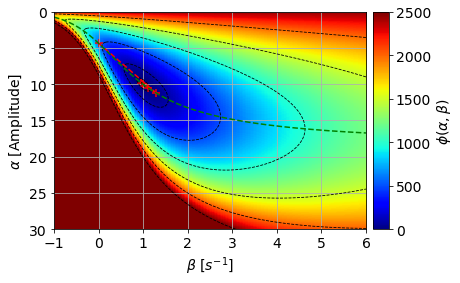

In [22]:
#Looking at the optimization path
fig,ax=plt.subplots()
plt.scatter(b_smpld,a_smpld,color='red',s=80,marker="+")
plt.plot(b_smpld,a_smpld,"--",color='red')
plt.plot(b_samples,a_opt,"--",color='green')
im=plt.imshow(obj_l2,vmin=0.0,vmax=2500,cmap='jet',extent=[-1.0,6.0,30.0,0.0])
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r"$\alpha$ "+"[Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],extent=[-1.0,6.0,0.0,30.0],
                 colors="black",linewidths=(0.8,),linestyles=('--'))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\phi(\alpha,\beta)$')
ax.set_aspect('auto')

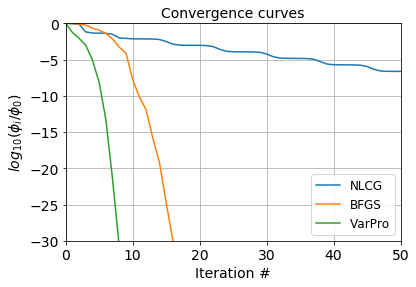

In [23]:
#Plotting convergence curves
fig,ax=plt.subplots()
plt.plot(range(len(objNLCG)),np.log10(objNLCG/objNLCG[0]+1e-40),label='NLCG')
plt.plot(range(len(objBFGS)),np.log10(objBFGS/objBFGS[0]+1e-40),label='BFGS')
plt.plot(range(len(objVPBFGS)),np.log10(objVPBFGS/objVPBFGS[0]+1e-40),label='VarPro')
plt.grid()
plt.title("Convergence curves")
plt.xlabel("Iteration #")
plt.ylabel("$log_{10}(\phi_i/\phi_0)$")
ax.legend()
plt.xlim(0,50)
_=plt.ylim(-30,0)

In [24]:
niter = 1000
Stop  = Stopper.BasicStopper(niter=niter,tolr=1e-32,tolg=1e-32)
NLCGsolver = NLCG(Stop,beta_type="FR")
model_init = model_test
model_initNp = model_init.getNdArray()
a_initial = 2.0
b_initial = 0.0
model_initNp[0] = a_initial
model_initNp[1] = b_initial
#Setting initial model
_=L2_sym.get_obj(model_init)
L2_sym.setDefaults()
NLCGsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
NLCGsolver.run(L2_sym,verbose=True)
print("Computational time %s s"%(time.time()-t0))
objNLCG = np.copy(NLCGsolver.obj)
#Converting sampled points to arrays for plotting
a_smpld_NLCG=[]
b_smpld_NLCG=[]
for iter in range(len(NLCGsolver.model)):
    a_smpld_NLCG.append(NLCGsolver.model[iter].getNdArray()[0])
    b_smpld_NLCG.append(NLCGsolver.model[iter].getNdArray()[1])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER 
	Restart folder: /tmp/restart_2020-07-16T11-54-37.026887/
	Conjugate method used: FR
##########################################################################################

iter = 0000, obj = 1.13543e+03, resnorm = 4.77e+01, gradnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 9.96829e+02, resnorm = 4.47e+01, gradnorm = 3.24e+02, feval = 4, geval = 2
iter = 0002, obj = 8.41188e+02, resnorm = 4.10e+01, gradnorm = 1.30e+03, feval = 7, geval = 3
iter = 0003, obj = 7.44506e+01, resnorm = 1.22e+01, gradnorm = 2.48e+02, feval = 10, geval = 4
iter = 0004, obj = 5.25159e+01, resnorm = 1.02e+01, gradnorm = 8.37e+01, feval = 13, geval = 5
iter = 0005, obj = 5.01772e+01, resnorm = 1.00e+01, gradnorm = 4.34e+01, feval = 16, geval = 6
iter = 0006, obj = 4.78102e+01, resnorm = 9.78e+00, gradnorm = 1.03e+02, feval = 19, geval = 7
iter = 0007, obj = 3.51325e+0

iter = 0143, obj = 4.05444e-15, resnorm = 9.00e-08, gradnorm = 1.65e-06, feval = 430, geval = 144
iter = 0144, obj = 2.72410e-15, resnorm = 7.38e-08, gradnorm = 2.78e-06, feval = 433, geval = 145
iter = 0145, obj = 1.12337e-15, resnorm = 4.74e-08, gradnorm = 1.97e-06, feval = 436, geval = 146
iter = 0146, obj = 6.52468e-16, resnorm = 3.61e-08, gradnorm = 8.22e-07, feval = 439, geval = 147
iter = 0147, obj = 5.78226e-16, resnorm = 3.40e-08, gradnorm = 3.24e-07, feval = 442, geval = 148
iter = 0148, obj = 5.65621e-16, resnorm = 3.36e-08, gradnorm = 1.70e-07, feval = 445, geval = 149
iter = 0149, obj = 5.59908e-16, resnorm = 3.35e-08, gradnorm = 1.78e-07, feval = 448, geval = 150
iter = 0150, obj = 5.45030e-16, resnorm = 3.30e-08, gradnorm = 3.52e-07, feval = 451, geval = 151
iter = 0151, obj = 4.68282e-16, resnorm = 3.06e-08, gradnorm = 7.74e-07, feval = 454, geval = 152
iter = 0152, obj = 2.51382e-16, resnorm = 2.24e-08, gradnorm = 9.61e-07, feval = 457, geval = 153
iter = 0153, obj = 1

iter = 0228, obj = 1.10923e-24, resnorm = 1.49e-12, gradnorm = 8.20e-12, feval = 685, geval = 229
iter = 0229, obj = 1.09912e-24, resnorm = 1.48e-12, gradnorm = 1.10e-11, feval = 688, geval = 230
iter = 0230, obj = 1.06467e-24, resnorm = 1.46e-12, gradnorm = 1.68e-11, feval = 691, geval = 231
iter = 0231, obj = 8.06337e-25, resnorm = 1.27e-12, gradnorm = 3.74e-11, feval = 694, geval = 232
iter = 0232, obj = 5.04398e-25, resnorm = 1.00e-12, gradnorm = 4.34e-11, feval = 697, geval = 233
iter = 0233, obj = 2.98341e-25, resnorm = 7.72e-13, gradnorm = 2.96e-11, feval = 700, geval = 234
iter = 0234, obj = 2.24963e-25, resnorm = 6.71e-13, gradnorm = 1.53e-11, feval = 703, geval = 235
iter = 0235, obj = 2.04594e-25, resnorm = 6.40e-13, gradnorm = 6.88e-12, feval = 706, geval = 236
iter = 0236, obj = 2.00956e-25, resnorm = 6.34e-13, gradnorm = 3.83e-12, feval = 709, geval = 237
iter = 0237, obj = 1.99576e-25, resnorm = 6.32e-13, gradnorm = 3.13e-12, feval = 712, geval = 238
iter = 0238, obj = 1

In [25]:
BFGSsolver = LBFGS(Stop)
#Setting initial model
_=L2_sym.get_obj(model_init)
L2_sym.setDefaults()
BFGSsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
BFGSsolver.run(L2_sym,verbose=True)
objBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s"%(time.time()-t0))
#Converting sampled points to arrays for plotting
a_smpld_BFGS=[]
b_smpld_BFGS=[]
for iter in range(len(BFGSsolver.model)):
    a_smpld_BFGS.append(BFGSsolver.model[iter].getNdArray()[0])
    b_smpld_BFGS.append(BFGSsolver.model[iter].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2020-07-16T11-54-39.187077/
##########################################################################################

iter = 0000, obj = 1.13543e+03, resnorm = 4.77e+01, gradnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 1.11043e+03, resnorm = 4.71e+01, gradnorm = 1.60e+03, feval = 2, geval = 2
iter = 0002, obj = 8.57238e+02, resnorm = 4.14e+01, gradnorm = 3.54e+02, feval = 3, geval = 3
iter = 0003, obj = 7.01722e+02, resnorm = 3.75e+01, gradnorm = 3.41e+02, feval = 4, geval = 4
iter = 0004, obj = 2.47522e+02, resnorm = 2.22e+01, gradnorm = 4.44e+02, feval = 5, geval = 5
iter = 0005, obj = 1.32921e+02, resnorm = 1.63e+01, gradnorm = 4.20e+02, feval = 6, geval = 6
iter = 0006, obj = 4.55506e+01, resnorm = 9.54e+00, gradnorm = 3.18e+02, feval = 7, geval = 7
iter = 0007, obj = 7.69313e+00, resnorm = 3.92e+00,

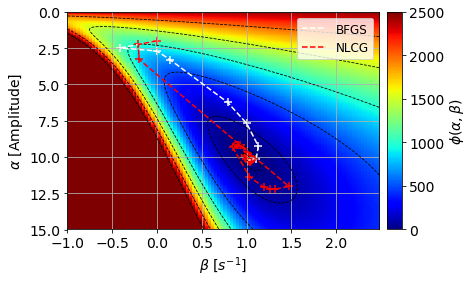

In [31]:
Na=250
Nb=100
#Looking at the optimization path
fig,ax=plt.subplots()
plt.scatter(b_smpld_BFGS,a_smpld_BFGS,color='white',s=50,marker="+")
plt.plot(b_smpld_BFGS,a_smpld_BFGS,"--",color='white',label="BFGS")
plt.scatter(b_smpld_NLCG,a_smpld_NLCG,color='red',s=50,marker="+")
plt.plot(b_smpld_NLCG,a_smpld_NLCG,"--",color='red',label="NLCG")
im=plt.imshow(obj_l2[0:Na,0:Nb],vmin=0.0,vmax=2500,cmap='jet',
              extent=[b_samples[0],b_samples[Nb-1],a_samples[Na-1],a_samples[0]])
plt.xlabel(r"$\beta$ "+"[$s^{-1}$]")
plt.ylabel(r"$\alpha$ "+"[Amplitude]")
plt.grid()
cs = plt.contour(obj_l2[0:Na,0:Nb],levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],
                 extent=[b_samples[0],b_samples[Nb-1],a_samples[0],a_samples[Na-1]],
                 colors="black",linewidths=(0.8,),linestyles=('--'))
plt.scatter(b_smpld_BFGS[0],a_smpld_BFGS[0],color='green',s=70,marker="+")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\phi(\alpha,\beta)$')
ax.set_aspect('auto')
ax.legend()
plt.savefig('exp-obj-sym-paths.pdf', format='pdf', dpi=300, bbox_inches='tight')